# BL40A2020 Wireless Communication Systems

## Assignment  week 5: Optimal demodulation

## Author: Eero Suomalainen

### Follow the steps done in the [notes](https://github.com/pedrohjn/wireless-comm/blob/master/Week%205/week5.ipynb) to analyze the *[8PSK](https://komm.readthedocs.io/en/latest/komm.PSKModulation/)* modulation

**1. Signal constelation with noise for $E_b/N_0 = 12$dB. You can reuse the code provided in this [link](https://github.com/rwnobrega/komm/blob/master/demo/constellations.ipynb), which is also available in the material provided in Azure.**

In [1]:
! pip install komm
! pip install sympy
! pip install matplotlib

In [2]:
import math
import komm
import sympy as sp
from sympy.stats import Normal, density, E, std, cdf
sp.init_printing() 
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
import ipywidgets

In [3]:
def constellation_demo(modulation, noise_power_db, xlim, ylim):
    awgn = komm.AWGNChannel()

    num_symbols = 10000
    noise_power = 10**(noise_power_db / 10)
    awgn.signal_power = modulation.energy_per_symbol
    awgn.snr = awgn.signal_power / noise_power
    num_bits = modulation.bits_per_symbol * num_symbols
    bits = np.random.randint(2, size=num_bits)
    sentword = modulation.modulate(bits)
    recvword = awgn(sentword)

    _, ax = plt.subplots(figsize=(16, 10))
    ax.scatter(recvword.real, recvword.imag, color='xkcd:light blue', s=1)
    ax.scatter(modulation.constellation.real, modulation.constellation.imag, color='xkcd:blue', s=8**2)
    for (i, point) in enumerate(modulation.constellation):
        binary_label = ''.join(str(b) for b in komm.int2binlist(modulation.labeling[i], width=modulation.bits_per_symbol))
        ax.text(point.real, point.imag + 0.075 * xlim[0], binary_label, horizontalalignment='center')
    ax.set_title(repr(modulation))
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    ax.axis('square')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(color='r', linestyle='--', linewidth=1)
    info_text = 'SNR = {:.1f} dB\n'.format(10*np.log10(awgn.snr))
    info_text += 'Eb/N0 = {:.1f} dB'.format(12)
    #10*np.log10(awgn.snr / modulation.bits_per_symbol)
    ax.text(1.125 * xlim[1], 0.0, info_text, horizontalalignment='left', verticalalignment='center')
    plt.show()

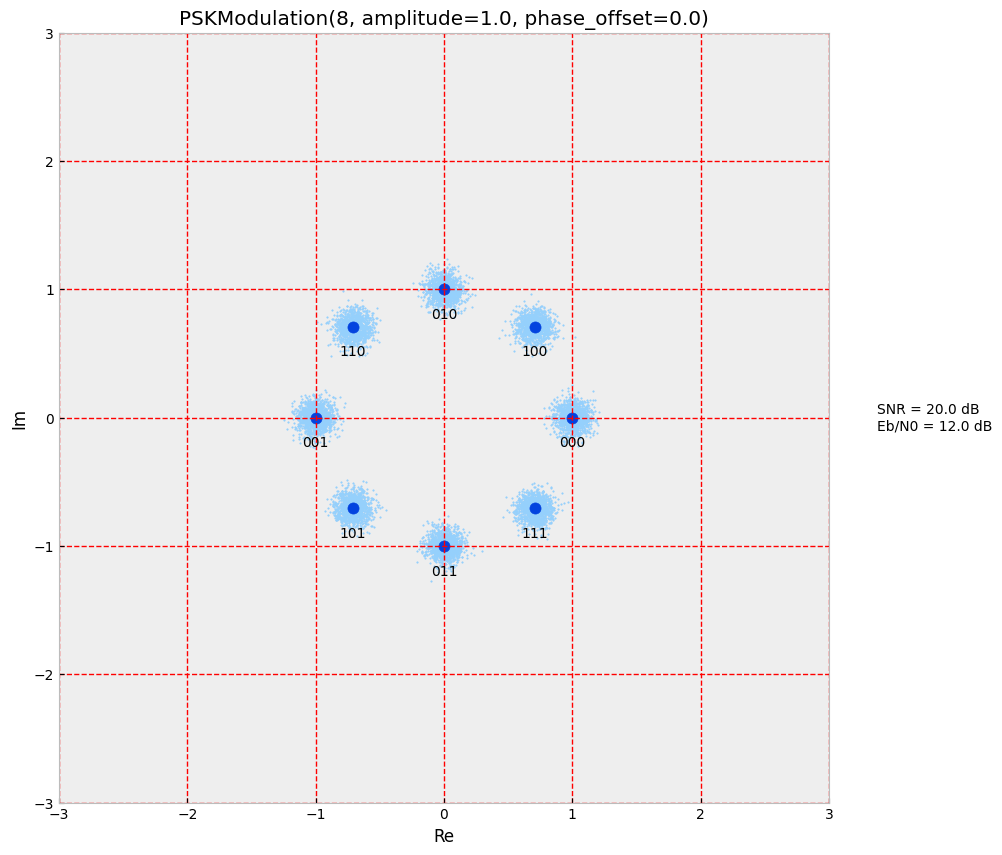

In [7]:
order = 8
amplitude=1
phase_offset=0
labeling='natural'
noise_power_db=-20

psk_modulation = komm.PSKModulation(order, amplitude, phase_offset, labeling)
constellation_demo(psk_modulation, noise_power_db, xlim=[-3.0, 3.0], ylim=[-3.0, 3.0])

**2. Numerical example:** Assume the following equation:

$$u_\mathrm{p}(t) = u_\mathrm{c}(t)\cos(2\pi 600 t) - u_\mathrm{s}(t)\sin(2\pi 600 t)$$

Considering an AWGN channel so that $E_b/N_0 = 12$dB, plot the wave form for a random binary sequence of $18$ bits considering an information rate of 300 bits per second.

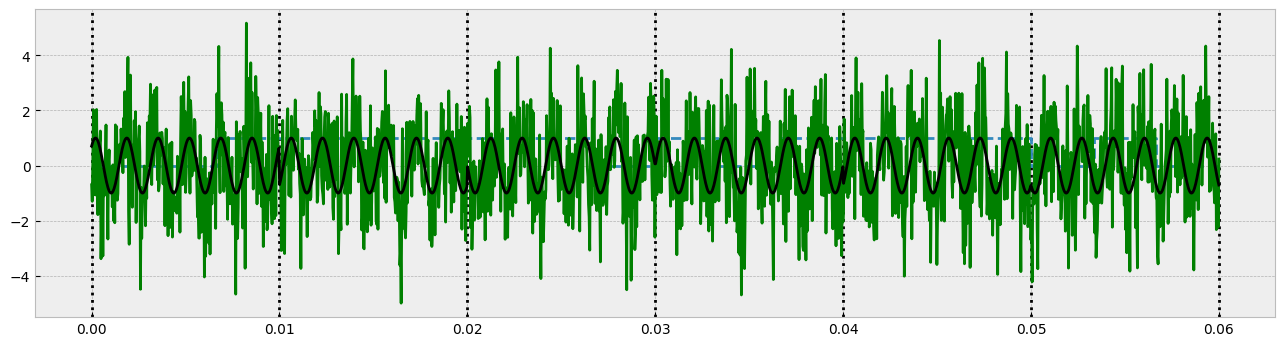

In [8]:
M=8
psk = komm.PSKModulation(M)
#
observations = int
observations = 6 # number sequences of 3 bits
rate = 300
input_seq_size = observations * np.log2(M).astype(int)
time_of_obs = input_seq_size/rate
tp = np.arange(0, input_seq_size, 1)/rate 
input_seq = np.random.randint(2, size=input_seq_size)
input_seq_plot = np.append(input_seq,input_seq[input_seq_size-1])
tp_plot = np.append(tp,tp[input_seq_size-1]+1/rate)
##
n_samples = 100
tmod_points = n_samples*input_seq_size
#
tmod = np.linspace(0, tp_plot[input_seq_size], tmod_points)
#
input_wave_aux = psk.modulate(input_seq)
input_wave_I = np.zeros(tmod_points)
input_wave_Q = np.zeros(tmod_points)

##################################
for i in range(0,tmod_points):
    a = math.floor(i/(n_samples*np.log2(M)))
    for j in range(M):
        if np.around(input_wave_aux[a],decimals=3) == np.around(psk.constellation[j],decimals=3): 
            input_wave_I[i] = psk.constellation[j].real 
            input_wave_Q[i] = psk.constellation[j].imag
###

t,fc = sp.symbols('t,f_c')
uc = sp.cos(2*sp.pi*fc*t)
us = sp.sin(2*sp.pi*fc*t)
freq_c = 600
modulation_I = sp.lambdify(t,uc.subs(fc,freq_c),"numpy")
modulation_Q = sp.lambdify(t,us.subs(fc,freq_c),"numpy")
###
plt.rcParams['figure.figsize'] = 16, 4
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k');
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--')

mu, sigma = 0, 1 # mean and standard deviation
noiseQ = np.random.normal(mu, sigma, tmod_points)
noiseI = np.random.normal(mu, sigma, tmod_points)
plt.plot(tmod,(input_wave_I*modulation_I(tmod) + noiseI) - (input_wave_Q*modulation_Q(tmod) + noiseQ),'g')


plt.plot(tmod,input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod),'k')
plt.show()

**3. Performance analysis:** Plot the figure *error probability vs. $E_b/N_0$* assuming that the 0's and 1's in the input sequence are equally distributed. Consider two curves, symbol error probability and bit error probability.

- $d_\mathrm{min} = \sqrt{2}/2$ (in the case considered before)


- $\bar{N}_{d_\mathrm{min}} = 2$ (Each signal point has two neighbors)

- Energy per symbol = average energy in Q + average energy in I: $E_\mathrm{s} = 2 \cdot (0.5 \cdot 0^2 + 0.5  \cdot 1^2) = 1$


- Energy per bit: $E_\mathrm{b} = \dfrac{E_\mathrm{s}}{\log_2M} = \dfrac{1}{\log_28} = 1/3$

- $\eta_\mathrm{P} = \dfrac{d_\mathrm{min}^2}{E_\mathrm{b}} = \dfrac{(\sqrt{2}/2)^2}{1/3} = 1.5$

- $P_\mathrm{e} \approx \bar{N}_{d_\mathrm{min}} Q\left( \sqrt{\dfrac{\eta_\mathrm{P} E_\mathrm{b}}{2N_0}} \right) = 2 Q\left( \sqrt{\dfrac{1.5 E_\mathrm{b}}{2N_0}} \right) = 2 Q\left(\sqrt{ \dfrac{3 E_\mathrm{b}}{4N_0} }\right) $

- $P_\mathrm{bit} = Q\left(\sqrt{ \dfrac{3 E_\mathrm{b}}{4N_0} }\right)$

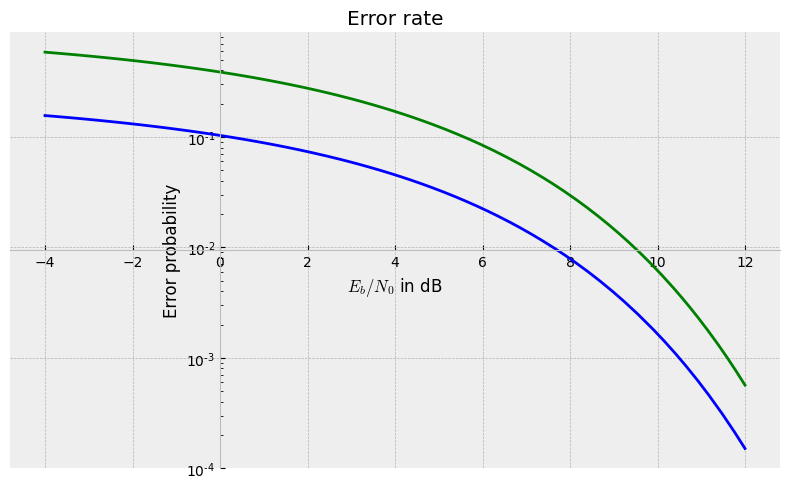

In [9]:
y = sp.Symbol("y")
def Q(x):
    return sp.simplify(1/2 * sp.erfc(x/sp.sqrt(2)))

plt.rcParams['figure.figsize'] = 8, 5
plot_aux = sp.plot(sp.N(2*Q(sp.sqrt( 3/4 * 10**(y/10)))), 16/30 * sp.N(Q(sp.sqrt( 3/4 * 10**(y/10)))),(y,-4,12),xlabel='$E_b/N_0$ in dB',
        ylabel='Error probability', yscale= 'log', title='Error rate',show=False);
plot_aux[0].line_color = 'g'
plot_aux[1].line_color = 'b'
plot_aux.show()

**4. Decision rule:** If the input sequence is not equally distributed, the optimal decision rule changes. With your own words, explain why MAP outperforms ML.

As MAP minimises error propability and error probability is higher when input sequence is unevenly distributed, MAP outperforms ML when input events are distributed unevenly.